# OSOAA Radiative Transfer Simulation Tutorial
## Focus: Water-Leaving Radiance

This notebook guides you through running OSOAA (Ocean Successive Orders with Atmosphere - Advanced) simulations and analyzing water-leaving radiance outputs.

**OSOAA** is a vector radiative transfer model for coupled atmosphere-ocean systems. It computes radiance and polarization using the successive orders of scattering method.

### What you'll learn:
1. Setting up OSOAA simulation parameters
2. Running the Fortran executable from Python
3. Parsing and visualizing water-leaving radiance
4. Understanding the effect of chlorophyll concentration
5. Exploring spectral and angular dependencies

## 1. Setup and Configuration

In [1]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile
import shutil
from pathlib import Path
from typing import Dict, Optional, List

# Set up paths - adjust OSOAA_ROOT to your installation
OSOAA_ROOT = Path(os.environ.get('OSOAA_ROOT', Path.cwd().parent)).resolve()
OSOAA_EXE = OSOAA_ROOT / 'exe' / 'OSOAA_MAIN.exe'
OSOAA_FIC = OSOAA_ROOT / 'fic'

# Set environment variable for the executable
os.environ['OSOAA_ROOT'] = str(OSOAA_ROOT)

print(f"OSOAA Root: {OSOAA_ROOT}")
print(f"Executable exists: {OSOAA_EXE.exists()}")
print(f"Data files directory exists: {OSOAA_FIC.exists()}")

OSOAA Root: /home/xavier/Projects/Oceanography/python/RadiativeTransferCode-OSOAA
Executable exists: True
Data files directory exists: True


## 2. OSOAA Python Wrapper Class

We'll create a simple Python class to interface with the OSOAA Fortran executable.

**Important notes about OSOAA:**
- OSOAA uses **command-line arguments** with `-Keyword Value` format
- Wavelength is specified in **micrometers** (not nanometers)
- Output files are written to `Standard_outputs/` subdirectory within the working directory
- Imaginary refractive indices must be **negative** (absorption convention)

In [2]:
class OSOAASimulation:
    """
    Python wrapper for OSOAA radiative transfer simulations.
    
    This class handles:
    - Parameter configuration with correct OSOAA keywords
    - Execution of the Fortran code via command-line arguments
    - Parsing of output files
    """
    
    def __init__(self, osoaa_root: Path, work_dir: Optional[Path] = None):
        self.osoaa_root = Path(osoaa_root).resolve()
        self.exe_path = self.osoaa_root / 'exe' / 'OSOAA_MAIN.exe'
        self.fic_path = self.osoaa_root / 'fic'
        
        # Create working directory with required subdirectories
        if work_dir:
            self.work_dir = Path(work_dir).resolve()
        else:
            self.work_dir = Path(tempfile.mkdtemp(prefix='osoaa_'))
        
        # Create directories for Mie calculations and surface matrices
        self.mie_aer_dir = self.work_dir / 'MIE_AER'
        self.mie_hyd_dir = self.work_dir / 'MIE_HYD'
        self.surf_dir = self.work_dir / 'SURF'
        
        self.mie_aer_dir.mkdir(parents=True, exist_ok=True)
        self.mie_hyd_dir.mkdir(parents=True, exist_ok=True)
        self.surf_dir.mkdir(parents=True, exist_ok=True)
        
        if not self.exe_path.exists():
            raise FileNotFoundError(f"OSOAA executable not found at {self.exe_path}")
        
        print(f"Working directory: {self.work_dir}")
    
    def get_default_params(self, wavelength_nm: float = 550.0, 
                           solar_zenith: float = 30.0,
                           chlorophyll: float = 0.1,
                           aot: float = 0.1,
                           wind_speed: float = 5.0) -> Dict:
        """
        Generate default simulation parameters.
        
        Parameters
        ----------
        wavelength_nm : float
            Simulation wavelength in nm (will be converted to micrometers)
        solar_zenith : float
            Solar zenith angle in degrees (0-90)
        chlorophyll : float
            Chlorophyll-a concentration in mg/m³
        aot : float
            Aerosol optical thickness at reference wavelength
        wind_speed : float
            Wind speed in m/s for sea surface roughness
        """
        # Convert wavelength from nm to micrometers
        wavelength_um = wavelength_nm / 1000.0
        
        return {
            # Working directory (required)
            'OSOAA.ResRoot': str(self.work_dir),
            
            # Wavelength in micrometers
            'OSOAA.Wa': wavelength_um,
            
            # Solar geometry
            'ANG.Thetas': solar_zenith,
            
            # Viewing geometry
            'OSOAA.View.Phi': 90.0,       # Relative azimuth angle (degrees)
            'OSOAA.View.Level': 4,         # 4 = Sea Surface 0- (just below surface)
            'OSOAA.View.Z': 0.0,           # Depth for output
            
            # Atmospheric profile
            'AP.Pressure': 1013.0,         # Surface pressure (hPa)
            'AP.HR': 8.0,                  # Rayleigh scale height (km)
            'AP.HA': 2.0,                  # Aerosol scale height (km)
            
            # Aerosol model - mono-modal log-normal distribution (Model 0, SDtype 1)
            'AER.DirMie': str(self.mie_aer_dir),
            'AER.Waref': wavelength_um,    # Reference wavelength (micrometers)
            'AER.AOTref': aot,             # AOT at reference wavelength
            'AER.Model': 0,                # Mono-modal model
            'AER.MMD.MRwa': 1.45,          # Real refractive index
            'AER.MMD.MIwa': -0.001,        # Imaginary refractive index (MUST be negative)
            'AER.MMD.SDtype': 1,           # 1 = Log-Normal Distribution
            'AER.MMD.LNDradius': 0.10,     # Modal radius (micrometers)
            'AER.MMD.LNDvar': 0.46,        # Log of standard deviation
            
            # Sea profile
            'SEA.Depth': 100.0,            # Ocean depth (m)
            
            # Hydrosol model - Junge phytoplankton (Model 1)
            'HYD.DirMie': str(self.mie_hyd_dir),
            'HYD.Model': 1,                # 1 = Use phytoplankton Junge model
            'PHYTO.Chl': chlorophyll,      # Chlorophyll concentration (mg/m³)
            'PHYTO.ProfilType': 1,         # 1 = Homogeneous profile
            
            # Phytoplankton optical properties (Junge distribution)
            'PHYTO.JD.slope': 4.0,         # Junge slope
            'PHYTO.JD.rmin': 0.01,         # Minimum radius (micrometers)
            'PHYTO.JD.rmax': 200.0,        # Maximum radius (micrometers)
            'PHYTO.JD.MRwa': 1.05,         # Real refractive index
            'PHYTO.JD.MIwa': 0.0,          # Imaginary refractive index
            'PHYTO.JD.rate': 1.0,          # Fraction of this mode
            
            # Sediments and dissolved matter
            'SED.Csed': 0.0,               # Sediment concentration (mg/L)
            'YS.Abs440': 0.0,              # Yellow substance absorption at 440nm
            'DET.Abs440': 0.0,             # Detritus absorption at 440nm
            
            # Sea surface
            'SEA.Dir': str(self.surf_dir),
            'SEA.Ind': 1.34,               # Refractive index of seawater
            'SEA.Wind': wind_speed,        # Wind speed (m/s)
            'SEA.SurfAlb': 0.0,            # Surface albedo
            'SEA.BotType': 1,              # Bottom type
            'SEA.BotAlb': 0.30,            # Bottom albedo
            
            # Output files
            'OSOAA.ResFile.vsVZA': 'LUM_vsVZA.txt',
        }
    
    def build_command(self, params: Dict) -> List[str]:
        """Build command-line arguments for OSOAA."""
        cmd = [str(self.exe_path)]
        for key, value in params.items():
            cmd.extend([f'-{key}', str(value)])
        return cmd
    
    def run(self, params: Dict, verbose: bool = True, timeout: int = 600) -> Dict:
        """
        Run OSOAA simulation with given parameters.
        
        Returns dictionary with parsed results.
        """
        # Build command
        cmd = self.build_command(params)
        
        if verbose:
            wl_nm = params.get('OSOAA.Wa', 0) * 1000
            print(f"Running OSOAA simulation...")
            print(f"  Wavelength: {wl_nm:.1f} nm")
            print(f"  Chlorophyll: {params.get('PHYTO.Chl', 'N/A')} mg/m³")
            print(f"  Solar zenith: {params.get('ANG.Thetas', 'N/A')}°")
            print(f"  AOT: {params.get('AER.AOTref', 'N/A')}")
        
        # Run simulation
        result = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            cwd=str(self.osoaa_root),
            env={**os.environ, 'OSOAA_ROOT': str(self.osoaa_root)},
            timeout=timeout
        )
        
        if result.returncode != 0:
            print(f"OSOAA Error (return code {result.returncode}):")
            print("STDOUT:", result.stdout[:3000] if result.stdout else "(empty)")
            print("STDERR:", result.stderr[:2000] if result.stderr else "(empty)")
            raise RuntimeError(f"OSOAA simulation failed")
        
        if verbose:
            print("  Simulation completed successfully!")
        
        # Parse results
        return self.parse_results(params)
    
    def parse_results(self, params: Dict) -> Dict:
        """Parse OSOAA output files into numpy arrays."""
        results = {'params': params}
        
        # Output files are in Standard_outputs subdirectory
        output_dir = self.work_dir / 'Standard_outputs'
        
        # Parse LUM_vsVZA.txt (radiance vs viewing zenith angle)
        vza_filename = params.get('OSOAA.ResFile.vsVZA', 'LUM_vsVZA.txt')
        vza_file = output_dir / vza_filename
        
        if vza_file.exists():
            results['vza_data'] = self._parse_vza_file(vza_file)
            results['output_file'] = str(vza_file)
        else:
            print(f"Warning: Output file not found: {vza_file}")
        
        return results
    
    def _parse_vza_file(self, filepath: Path) -> Dict:
        """
        Parse LUM_vsVZA.txt output file.
        
        Output columns:
        1: VZA - Viewing Zenith Angle (degrees)
        2: SCA_ANG - Scattering angle (degrees)
        3: I - Stokes I, normalized radiance (pi*L/Esun)
        4: REFL - Reflectance (pi*L/Ed)
        5: POL_RATE - Degree of polarization (%)
        6: LPOL - Polarized intensity
        7: REFL_POL - Polarized reflectance
        """
        # Read file and find data start (skip header lines)
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        # Find the line with column headers
        data_start = 0
        for i, line in enumerate(lines):
            if line.strip().startswith('VZA') and 'SCA_ANG' in line:
                data_start = i + 1
                break
        
        # Load data
        data = np.loadtxt(filepath, skiprows=data_start)
        
        return {
            'vza': data[:, 0],              # Viewing Zenith Angle (degrees)
            'scattering_angle': data[:, 1], # Scattering angle (degrees)
            'I': data[:, 2],                # Normalized radiance (pi*L/Esun)
            'reflectance': data[:, 3],      # Reflectance (pi*L/Ed)
            'DoLP': data[:, 4],             # Degree of polarization (%)
            'I_pol': data[:, 5],            # Polarized intensity
            'refl_pol': data[:, 6],         # Polarized reflectance
        }

print("OSOAASimulation class defined.")

OSOAASimulation class defined.


## 3. Your First OSOAA Simulation: Clear Water

Let's run a simple simulation for clear ocean water (low chlorophyll) at 550 nm.

In [3]:
# Initialize the simulation
sim = OSOAASimulation(OSOAA_ROOT)

# Get default parameters for clear water
params = sim.get_default_params(
    wavelength_nm=550.0,   # Green light (nm)
    solar_zenith=30.0,     # Sun at 30° from zenith
    chlorophyll=0.1,       # Clear oligotrophic water (mg/m³)
    aot=0.1,               # Low aerosol loading
    wind_speed=5.0         # Moderate sea surface (m/s)
)

print("\nSimulation parameters:")
for key, value in params.items():
    print(f"  -{key} {value}")

Working directory: /tmp/osoaa_y4aph9vm

Simulation parameters:
  -OSOAA.ResRoot /tmp/osoaa_y4aph9vm
  -OSOAA.Wa 0.55
  -ANG.Thetas 30.0
  -OSOAA.View.Phi 90.0
  -OSOAA.View.Level 4
  -OSOAA.View.Z 0.0
  -AP.Pressure 1013.0
  -AP.HR 8.0
  -AP.HA 2.0
  -AER.DirMie /tmp/osoaa_y4aph9vm/MIE_AER
  -AER.Waref 0.55
  -AER.AOTref 0.1
  -AER.Model 0
  -AER.MMD.MRwa 1.45
  -AER.MMD.MIwa -0.001
  -AER.MMD.SDtype 1
  -AER.MMD.LNDradius 0.1
  -AER.MMD.LNDvar 0.46
  -SEA.Depth 100.0
  -HYD.DirMie /tmp/osoaa_y4aph9vm/MIE_HYD
  -HYD.Model 1
  -PHYTO.Chl 0.1
  -PHYTO.ProfilType 1
  -PHYTO.JD.slope 4.0
  -PHYTO.JD.rmin 0.01
  -PHYTO.JD.rmax 200.0
  -PHYTO.JD.MRwa 1.05
  -PHYTO.JD.MIwa 0.0
  -PHYTO.JD.rate 1.0
  -SED.Csed 0.0
  -YS.Abs440 0.0
  -DET.Abs440 0.0
  -SEA.Dir /tmp/osoaa_y4aph9vm/SURF
  -SEA.Ind 1.34
  -SEA.Wind 5.0
  -SEA.SurfAlb 0.0
  -SEA.BotType 1
  -SEA.BotAlb 0.3
  -OSOAA.ResFile.vsVZA LUM_vsVZA.txt


In [4]:
# Run the simulation
results = sim.run(params)

# Show output summary
if 'vza_data' in results:
    vza = results['vza_data']['vza']
    I = results['vza_data']['I']
    print(f"\nOutput summary:")
    print(f"  VZA range: {vza.min():.1f}° to {vza.max():.1f}°")
    print(f"  Radiance range: {I.min():.6f} to {I.max():.6f}")
    
    # Nadir value (VZA closest to 0)
    nadir_idx = np.argmin(np.abs(vza))
    print(f"  Nadir radiance (VZA={vza[nadir_idx]:.1f}°): {I[nadir_idx]:.6f}")

Running OSOAA simulation...
  Wavelength: 550.0 nm
  Chlorophyll: 0.1 mg/m³
  Solar zenith: 30.0°
  AOT: 0.1
  Simulation completed successfully!

Output summary:
  VZA range: -89.1° to 89.1°
  Radiance range: 0.006167 to 0.010877
  Nadir radiance (VZA=-0.0°): 0.006189


## 4. Visualizing Water-Leaving Radiance

The key output for ocean color applications is the **water-leaving radiance** - the radiance that emerges from the ocean after scattering by water molecules and particles.

OSOAA outputs radiance normalized to the extraterrestrial solar irradiance: $\pi L / E_{sun}$

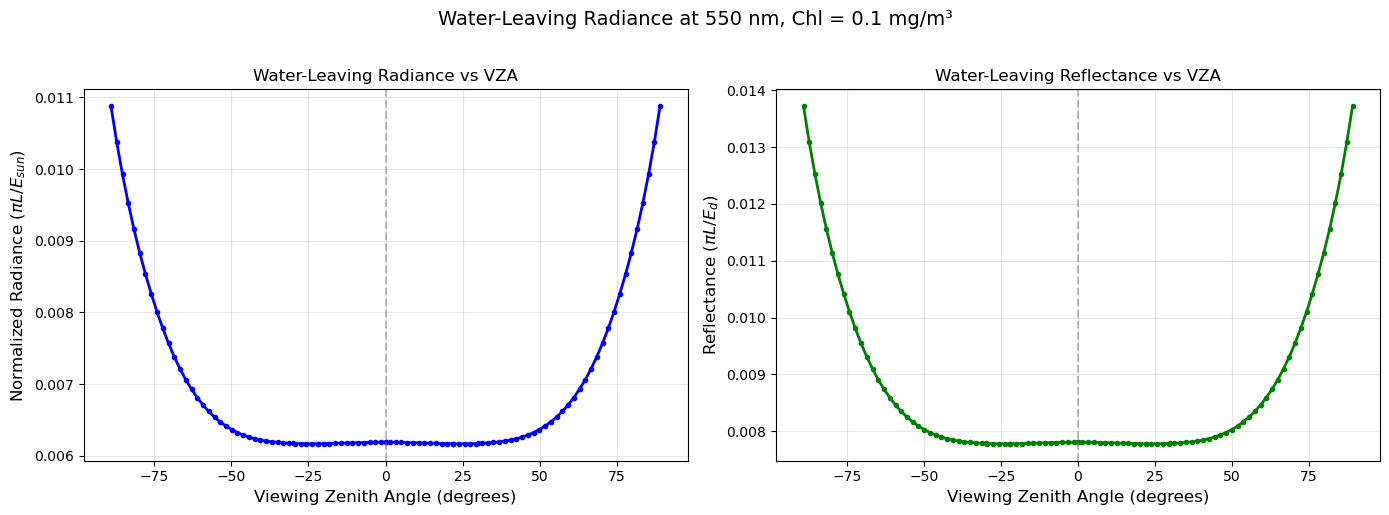

In [5]:
def plot_radiance_angular(results: Dict, title: str = None):
    """
    Plot water-leaving radiance as a function of viewing zenith angle.
    """
    if 'vza_data' not in results:
        print("No VZA data available")
        return
    
    vza = results['vza_data']['vza']
    radiance = results['vza_data']['I']
    reflectance = results['vza_data']['reflectance']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Normalized radiance
    axes[0].plot(vza, radiance, 'b-', linewidth=2, marker='o', markersize=3)
    axes[0].set_xlabel('Viewing Zenith Angle (degrees)', fontsize=12)
    axes[0].set_ylabel(r'Normalized Radiance ($\pi L / E_{sun}$)', fontsize=12)
    axes[0].set_title('Water-Leaving Radiance vs VZA', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # Plot 2: Reflectance
    axes[1].plot(vza, reflectance, 'g-', linewidth=2, marker='o', markersize=3)
    axes[1].set_xlabel('Viewing Zenith Angle (degrees)', fontsize=12)
    axes[1].set_ylabel(r'Reflectance ($\pi L / E_d$)', fontsize=12)
    axes[1].set_title('Water-Leaving Reflectance vs VZA', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    if title:
        fig.suptitle(title, fontsize=14, y=1.02)
    else:
        wl = results['params'].get('OSOAA.Wa', 0) * 1000
        chl = results['params'].get('PHYTO.Chl', '?')
        fig.suptitle(f'Water-Leaving Radiance at {wl:.0f} nm, Chl = {chl} mg/m³', fontsize=14, y=1.02)
    
    plt.tight_layout()
    return fig, axes

# Plot the results
plot_radiance_angular(results)
plt.show()

## 5. Effect of Chlorophyll Concentration

Chlorophyll concentration strongly affects water-leaving radiance, especially in the blue and green wavelengths. Let's explore this effect.

In [6]:
# Chlorophyll concentration series: from ultra-oligotrophic to eutrophic
chl_values = [0.03, 0.1, 0.3, 1.0, 3.0]  # mg/m³

chl_results = {}

print("Running chlorophyll series simulations...\n")
for chl in chl_values:
    params = sim.get_default_params(
        wavelength_nm=550.0,
        solar_zenith=30.0,
        chlorophyll=chl,
        aot=0.1,
        wind_speed=5.0
    )
    # Update output filename to avoid overwriting
    params['OSOAA.ResFile.vsVZA'] = f'LUM_vsVZA_chl{chl}.txt'
    
    try:
        chl_results[chl] = sim.run(params, verbose=False)
        print(f"  Chl = {chl:5.2f} mg/m³ - Done")
    except Exception as e:
        print(f"  Chl = {chl:5.2f} mg/m³ - Failed: {e}")

print("\nAll simulations completed!")

Running chlorophyll series simulations...

  Chl =  0.03 mg/m³ - Done
  Chl =  0.10 mg/m³ - Done
  Chl =  0.30 mg/m³ - Done
  Chl =  1.00 mg/m³ - Done
  Chl =  3.00 mg/m³ - Done

All simulations completed!


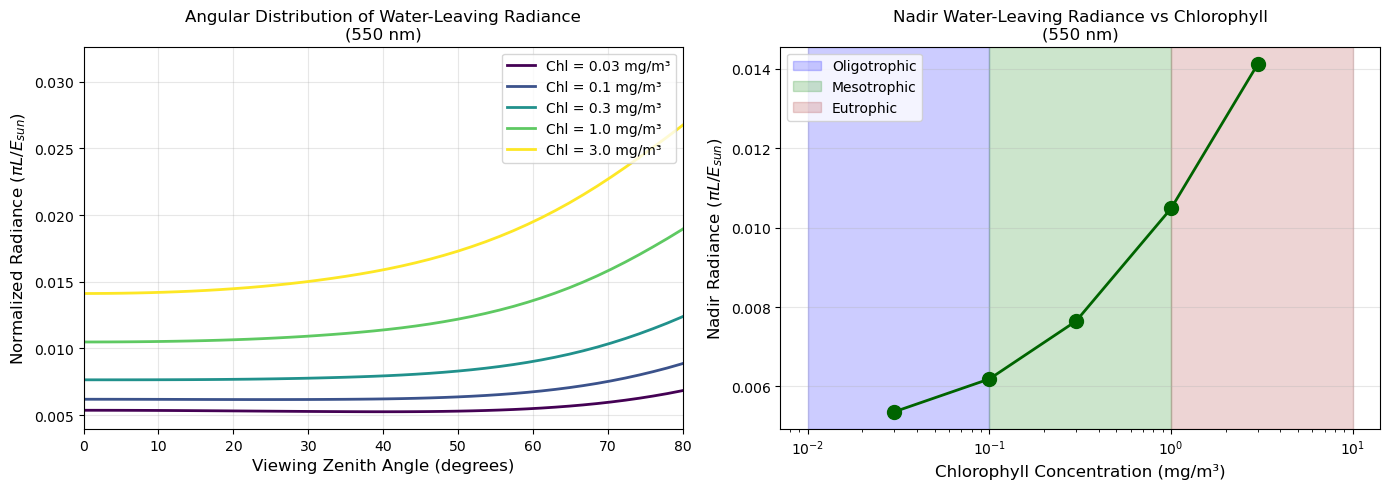

In [7]:
def plot_chlorophyll_series(chl_results: Dict):
    """
    Compare water-leaving radiance for different chlorophyll concentrations.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Color map for chlorophyll values
    colors = plt.cm.viridis(np.linspace(0, 1, len(chl_results)))
    
    nadir_radiances = []
    chl_vals = []
    
    # Plot 1: Angular distribution
    for (chl, result), color in zip(sorted(chl_results.items()), colors):
        if 'vza_data' in result:
            vza = result['vza_data']['vza']
            rad = result['vza_data']['I']
            
            # Only plot positive VZA for clarity
            mask = vza >= 0
            axes[0].plot(vza[mask], rad[mask], '-', color=color, linewidth=2, 
                        label=f'Chl = {chl} mg/m³')
            
            # Get nadir value
            nadir_idx = np.argmin(np.abs(vza))
            nadir_radiances.append(rad[nadir_idx])
            chl_vals.append(chl)
    
    axes[0].set_xlabel('Viewing Zenith Angle (degrees)', fontsize=12)
    axes[0].set_ylabel(r'Normalized Radiance ($\pi L / E_{sun}$)', fontsize=12)
    axes[0].set_title('Angular Distribution of Water-Leaving Radiance\n(550 nm)', fontsize=12)
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0, 80)
    
    # Plot 2: Nadir radiance vs Chlorophyll
    if nadir_radiances:
        axes[1].semilogx(chl_vals, nadir_radiances, 'o-', color='darkgreen', 
                        linewidth=2, markersize=10)
        axes[1].set_xlabel('Chlorophyll Concentration (mg/m³)', fontsize=12)
        axes[1].set_ylabel(r'Nadir Radiance ($\pi L / E_{sun}$)', fontsize=12)
        axes[1].set_title('Nadir Water-Leaving Radiance vs Chlorophyll\n(550 nm)', fontsize=12)
        axes[1].grid(True, alpha=0.3)
        
        # Add water type annotations
        axes[1].axvspan(0.01, 0.1, alpha=0.2, color='blue', label='Oligotrophic')
        axes[1].axvspan(0.1, 1.0, alpha=0.2, color='green', label='Mesotrophic')
        axes[1].axvspan(1.0, 10.0, alpha=0.2, color='brown', label='Eutrophic')
        axes[1].legend(loc='best')
    
    plt.tight_layout()
    return fig

if chl_results:
    plot_chlorophyll_series(chl_results)
    plt.show()

## 6. Spectral Water-Leaving Radiance

Ocean color remote sensing relies on the spectral shape of water-leaving radiance. Let's simulate across the visible spectrum.

In [8]:
# Wavelength range (visible spectrum) - common ocean color bands
wavelengths_nm = [443, 490, 510, 555, 670]  # nm

spectral_results = {}

print("Running spectral simulations...\n")
for wl in wavelengths_nm:
    params = sim.get_default_params(
        wavelength_nm=float(wl),
        solar_zenith=30.0,
        chlorophyll=0.3,  # Moderate chlorophyll
        aot=0.1,
        wind_speed=5.0
    )
    params['OSOAA.ResFile.vsVZA'] = f'LUM_vsVZA_wl{wl}.txt'
    
    try:
        spectral_results[wl] = sim.run(params, verbose=False)
        print(f"  λ = {wl} nm - Done")
    except Exception as e:
        print(f"  λ = {wl} nm - Failed: {e}")

print("\nSpectral simulations completed!")

Running spectral simulations...

  λ = 443 nm - Done
  λ = 490 nm - Done
  λ = 510 nm - Done
  λ = 555 nm - Done
  λ = 670 nm - Done

Spectral simulations completed!


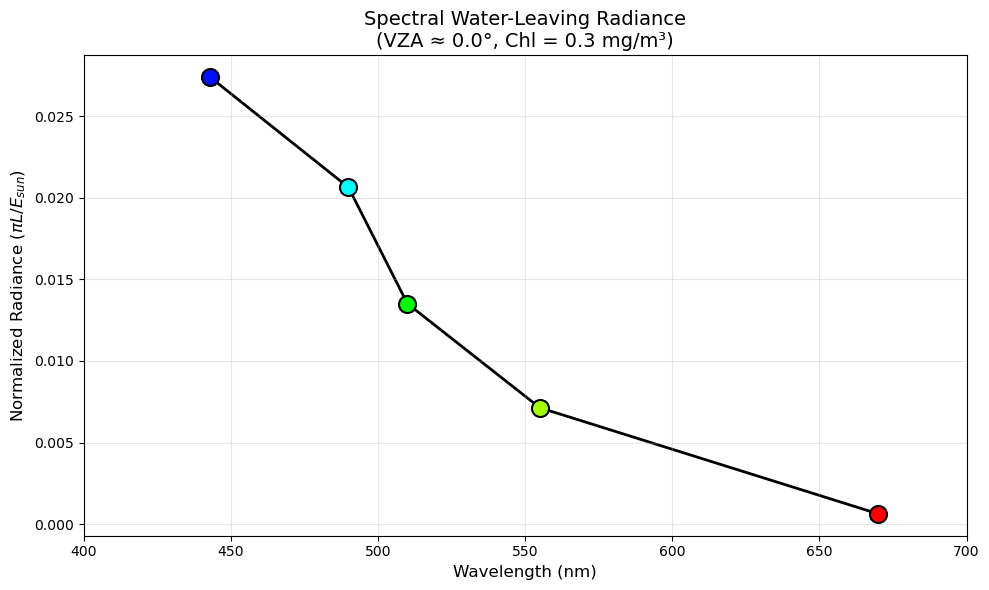

In [9]:
def wavelength_to_rgb(wavelength: float) -> tuple:
    """
    Convert wavelength (nm) to approximate RGB color.
    """
    if wavelength < 380:
        return (0.5, 0, 0.5)
    elif wavelength < 440:
        return (0.5 - 0.5*(wavelength-380)/(440-380), 0, 1)
    elif wavelength < 490:
        return (0, (wavelength-440)/(490-440), 1)
    elif wavelength < 510:
        return (0, 1, 1-(wavelength-490)/(510-490))
    elif wavelength < 580:
        return ((wavelength-510)/(580-510), 1, 0)
    elif wavelength < 645:
        return (1, 1-(wavelength-580)/(645-580), 0)
    elif wavelength < 780:
        return (1, 0, 0)
    else:
        return (0.5, 0, 0)

def plot_spectrum(spectral_results: Dict, viewing_angle: float = 0.0):
    """
    Plot water-leaving radiance spectrum at a given viewing angle.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    wavelengths = []
    radiances = []
    
    for wl, result in sorted(spectral_results.items()):
        if 'vza_data' in result:
            vza = result['vza_data']['vza']
            rad = result['vza_data']['I']
            
            # Find radiance at specified viewing angle
            idx = np.argmin(np.abs(vza - viewing_angle))
            wavelengths.append(wl)
            radiances.append(rad[idx])
    
    if wavelengths:
        # Create color gradient matching wavelength
        ax.plot(wavelengths, radiances, 'k-', linewidth=2, zorder=1)
        
        # Add colored points
        for wl, rad in zip(wavelengths, radiances):
            color = wavelength_to_rgb(wl)
            ax.scatter([wl], [rad], c=[color], s=150, zorder=2, edgecolors='black', linewidth=1.5)
        
        ax.set_xlabel('Wavelength (nm)', fontsize=12)
        ax.set_ylabel(r'Normalized Radiance ($\pi L / E_{sun}$)', fontsize=12)
        ax.set_title(f'Spectral Water-Leaving Radiance\n(VZA ≈ {viewing_angle}°, Chl = 0.3 mg/m³)', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(400, 700)
        
    plt.tight_layout()
    return fig

if spectral_results:
    plot_spectrum(spectral_results, viewing_angle=0.0)
    plt.show()

## 7. Polarization of Water-Leaving Radiance

OSOAA is a **vector** radiative transfer code, meaning it computes all Stokes parameters. The degree of linear polarization (DoLP) provides additional information about the scattering regime.

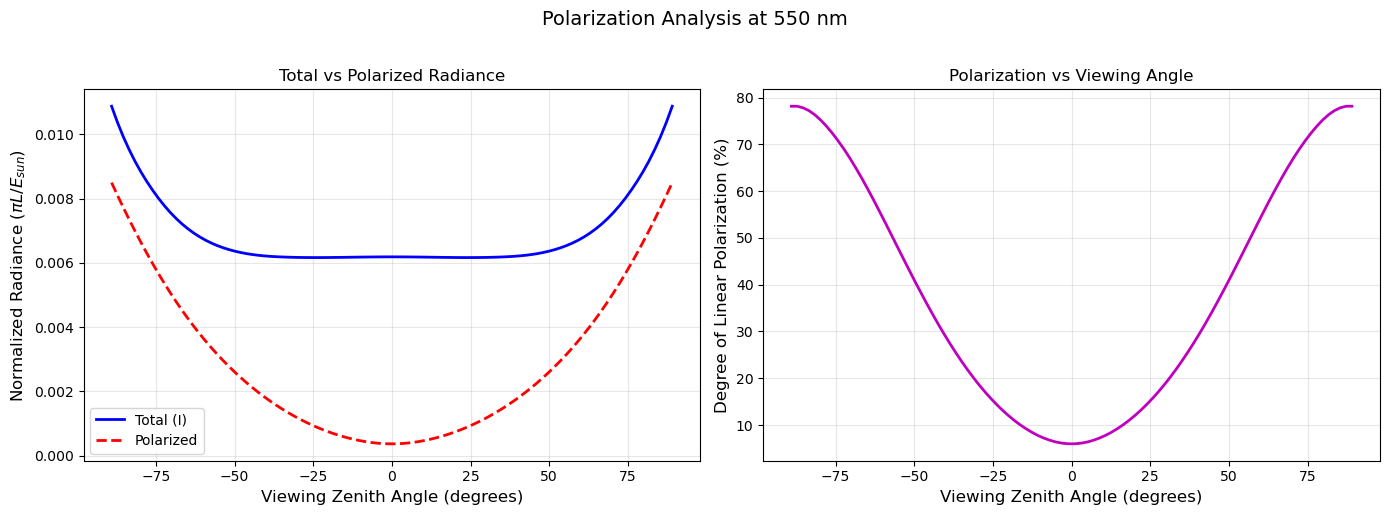

In [10]:
def plot_polarization(results: Dict):
    """
    Plot radiance and degree of linear polarization.
    """
    if 'vza_data' not in results:
        print("No VZA data available")
        return
    
    data = results['vza_data']
    vza = data['vza']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Total intensity
    axes[0].plot(vza, data['I'], 'b-', linewidth=2, label='Total (I)')
    axes[0].plot(vza, data['I_pol'], 'r--', linewidth=2, label='Polarized')
    axes[0].set_xlabel('Viewing Zenith Angle (degrees)', fontsize=12)
    axes[0].set_ylabel(r'Normalized Radiance ($\pi L / E_{sun}$)', fontsize=12)
    axes[0].set_title('Total vs Polarized Radiance', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Degree of Linear Polarization
    axes[1].plot(vza, data['DoLP'], 'm-', linewidth=2)
    axes[1].set_xlabel('Viewing Zenith Angle (degrees)', fontsize=12)
    axes[1].set_ylabel('Degree of Linear Polarization (%)', fontsize=12)
    axes[1].set_title('Polarization vs Viewing Angle', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    wl = results['params'].get('OSOAA.Wa', 0) * 1000
    fig.suptitle(f'Polarization Analysis at {wl:.0f} nm', fontsize=14, y=1.02)
    
    plt.tight_layout()
    return fig

if results and 'vza_data' in results:
    plot_polarization(results)
    plt.show()

## 8. Key Physical Insights

### Water-Leaving Radiance (Lw)

The **water-leaving radiance** is the radiance that emerges from the ocean surface after:
1. Solar radiation entering the water
2. Multiple scattering by water molecules and particles
3. Absorption by water, phytoplankton (chlorophyll), dissolved organic matter (CDOM), and suspended particles
4. Transmission through the air-sea interface

### OSOAA Output Quantities:

| Quantity | Symbol | Description |
|----------|--------|-------------|
| Normalized Radiance | $\pi L / E_{sun}$ | Radiance normalized to extraterrestrial irradiance |
| Reflectance | $\pi L / E_d$ | Radiance normalized to downwelling irradiance |
| DoLP | % | Degree of linear polarization |

### Factors Affecting Lw:

| Factor | Effect on Lw |
|--------|-------------|
| **Chlorophyll** | Increases absorption in blue (443 nm), enhances green reflectance |
| **CDOM** | Strong absorption in blue, decreases Lw at short wavelengths |
| **Sediments** | Increases backscattering, raises Lw especially in red |
| **Solar angle** | Higher SZA = longer path = more atmospheric effects |
| **Viewing angle** | Off-nadir viewing changes Fresnel reflectance |
| **Wind speed** | Affects surface roughness and sun glint patterns |

## 9. Summary and Next Steps

### What we learned:

1. **OSOAA** computes full Stokes vector radiance for coupled atmosphere-ocean systems
2. **Water-leaving radiance** is the key output for ocean color applications
3. **Chlorophyll** strongly affects the magnitude and spectral shape of Lw
4. **Angular distribution** of Lw depends on scattering phase functions
5. **Polarization** provides additional diagnostic information

### Suggested exercises:

1. Compare different aerosol types (change `AER.Model` to 2 for Shettle & Fenn models)
2. Explore the effect of wind speed on surface reflectance
3. Simulate different solar zenith angles (morning vs. noon)
4. Add CDOM (`YS.Abs440`) or suspended sediments (`SED.Csed`) to the simulation
5. Compare results with MODIS or VIIRS ocean color products

### Resources:

- OSOAA documentation: See `docs/` folder in the OSOAA installation
- Reference: Chami et al. (2015), Opt. Express 23, 27829-27852
- Demo script: `exe/run_OSOAA_demo.ksh` for full parameter reference

In [ ]:
# Clean up temporary files (optional)
cleanup = False  # Set to True to remove temporary files

if cleanup and hasattr(sim, 'work_dir'):
    print(f"Cleaning up: {sim.work_dir}")
    shutil.rmtree(sim.work_dir, ignore_errors=True)
else:
    print(f"Temporary files preserved in: {sim.work_dir}")
    print(f"Output files are in: {sim.work_dir / 'Standard_outputs'}")